---
title: Bayesian HMM with covariates
format: html
jupyter: python3
editor_options:
       chunk_output_type: inline
---

# Import and clean data

In [3]:
import pandas as pd
import numpy as np
from hmmlearn import hmm
import matplotlib.pyplot as plt
from pyprojroot import here
import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
from pyro.infer import SVI, TraceEnum_ELBO
from pyro.optim import Adam
from scipy.stats import poisson
import torch
import seaborn as sns

data = pd.read_csv(here("data/recent_donations.csv"))
data

# remove columns y_2020 to y_2023
# data = data.drop(columns=["y_2020", "y_2021", "y_2022", "y_2023"])

,unique_number,class_year,birth_year,first_donation_year,gender,y_2009,y_2010,y_2011,y_2012,y_2013,y_2014,y_2015,y_2016,y_2018,y_2019,y_2017,y_2020,y_2021,y_2022,y_2023
0,26308560,"(1960,1970]",1965,1985,M,0,0,0,0,0,0,0,0,0,0,0,1,1,3,1
1,26309283,"(1960,1970]",1966,2002,M,2,1,2,2,1,1,3,3,4,1,3,3,3,3,4
2,26317365,"(1960,1970]",1961,1984,M,4,2,3,3,3,4,3,3,2,3,3,2,0,1,0
3,26318451,"(1960,1970]",1967,1989,M,0,3,3,4,4,4,2,3,3,1,2,3,1,0,0
4,26319465,"(1960,1970]",1964,1994,F,1,2,2,1,2,1,1,0,0,2,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9231,27220599,"(1970,1980]",1980,2022,M,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0
9232,27220806,"(2000,2010]",2002,2022,M,0,0,0,0,0,0,0,0,0,0,0,0,0,2,3
9233,27221247,"(1990,2000]",2000,2022,F,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0
9234,27221274,"(1960,1970]",1966,2022,F,0,0,0,0,0,0,0,0,0,0,0,0,0,2,3


In [4]:
# ───────────────────────────────────────────────────────────────
#  Required libraries
# ───────────────────────────────────────────────────────────────
import polars as pl
import numpy as np
import torch

# ───────────────────────────────────────────────────────────────
# 1. Load data
# ───────────────────────────────────────────────────────────────
df = pl.from_pandas(data)                # or pl.read_csv("file.csv")

# ───────────────────────────────────────────────────────────────
# 2. Observed counts   obs  ∈  ℕ^{N×T}
# ───────────────────────────────────────────────────────────────
year_cols = sorted([c for c in df.columns if c.startswith("y_")])
T = len(year_cols)
obs = (df.select(year_cols)
         .fill_null(0)
         .to_numpy()
         .astype(int))                   # (N,T)

# ───────────────────────────────────────────────────────────────
# 3. Fixed covariates (for π)
# ───────────────────────────────────────────────────────────────
df = df.with_columns([
    (pl.col("gender") == "F").cast(pl.Int8).alias("gender_code"),
    ((pl.col("birth_year") - pl.col("birth_year").mean()) /
     pl.col("birth_year").std()).alias("birth_year_norm")
])

birth_year_norm = df["birth_year_norm"].to_numpy()        # (N,)
gender_code     = df["gender_code"].to_numpy()            # (N,)

# π-covariate matrix  (N,2)
cov_init = np.stack([birth_year_norm, gender_code], axis=1)

# ───────────────────────────────────────────────────────────────
# 4. Dynamic covariates (for A)
# ───────────────────────────────────────────────────────────────
years_num  = np.array([int(c[2:]) for c in year_cols])    # [2009, …, 2023]
ages       = years_num[None, :] - df["birth_year"].to_numpy()[:, None]
ages_norm  = (ages - ages.mean()) / ages.std()            # (N,T)

covid_mask = np.isin(years_num, [2020, 2021, 2022]).astype(float)  # (T,)
covid_years = np.tile(covid_mask, (df.height, 1))          # (N,T)

# A-covariate tensor (N,T,2)
cov_tran = np.stack([ages_norm, covid_years], axis=2)

# ───────────────────────────────────────────────────────────────
# 5. Torch tensors
# ───────────────────────────────────────────────────────────────
obs_torch      = torch.tensor(obs,      dtype=torch.long)
cov_init_torch = torch.tensor(cov_init, dtype=torch.float)   # (N,2)
cov_tran_torch = torch.tensor(cov_tran, dtype=torch.float)   # (N,T,2)

print("obs        :", obs_torch.shape)      # (N,T)
print("π covs     :", cov_init_torch.shape) # (N,2)
print("A covs     :", cov_tran_torch.shape) # (N,T,2)

obs        : torch.Size([9236, 15])
π covs     : torch.Size([9236, 2])
A covs     : torch.Size([9236, 15, 2])


The model uses two covariate blocks.  
$x^{\pi}_n = (\text{birth\_year\_norm},\;\text{gender\_code})\in\mathbb R^{2}$ affects the initial state,  
while $x^{A}_{n,t} = (\text{ages\_norm},\;\text{covid\_years})\in\mathbb R^{2}$ drives the transition at time $t$.  
Hidden state $z_{n,t}\in\{0,1,2\}$, observed count $y_{n,t}$.

Priors for the intercepts  
• $\pi_{\text{base}}\sim\text{Dirichlet}(\boldsymbol{\alpha}_{\pi})$  
• $A_{\text{base}}[k,\cdot]\sim\text{Dirichlet}(\boldsymbol{\alpha}_{A_k})$  
• $\lambda_k\sim\text{Gamma}(2,1)$ for $k=0,1,2$

Slope parameters to be learned  
• $W_\pi\in\mathbb R^{K\times2}$  
• $W_A\in\mathbb R^{K\times K\times2}$

Initial-state distribution  

$\Pr(z_{n,0}=k\mid x^{\pi}_n)=
\operatorname{softmax}_k\!\bigl(
\log\pi_{\text{base},k}+W_{\pi,k}\cdot x^{\pi}_n
\bigr).$

Transition dynamics  

$\Pr(z_{n,t}=j\mid z_{n,t-1}=k,\;x^{A}_{n,t})=
\operatorname{softmax}_j\!\bigl(
\log A_{\text{base},kj}+W_{A,kj}\cdot x^{A}_{n,t}
\bigr).$

Emission  

$y_{n,t}\mid z_{n,t}=k\sim\text{Poisson}(\lambda_k).$

Guide (variational family)  
Point-mass approximation:  
$q(\pi_{\text{base}})=\delta(\pi_{\text{base}}-\hat\pi)$,  
$q(A_{\text{base}})=\delta(A_{\text{base}}-\hat A)$.  
All $\lambda$, $W_\pi$, $W_A$ are deterministic `pyro.param`s, and discrete states $z_{n,t}$ are enumerated exactly.

Training setup  
Loss: `TraceEnum_ELBO(max_plate_nesting = 1)`  
Optimiser: `Adam(lr = 2·10^{-2})`

The learned parameters $\hat\pi,\hat A,W_\pi,W_A,\hat\lambda$ reveal how the covariates influence entry probabilities, transition behaviour and expected donation rates.

In [5]:
# ───────────────────────────────────────────────────────────────
#  Poisson-HMM con Dirichlet asimmetriche
# ───────────────────────────────────────────────────────────────
import torch, pyro, pyro.distributions as dist
from   pyro.infer  import SVI, TraceEnum_ELBO, config_enumerate
from   pyro.optim  import Adam

K        = 3
C_pi     = 2        # birth_year_norm , gender_code
C_A      = 2        # ages_norm , covid_years

#  α asimmetriche (sceglile come preferisci)
alpha_pi = torch.tensor([5., 2., 1.])                             # favorisce lo stato 0
alpha_A  = torch.tensor([[6.,1.,1.],                               # favorisce rimanere
                         [1.,6.,1.],
                         [1.,1.,6.]])

@config_enumerate
def model(obs, x_pi, x_A):
    N, T = obs.shape

    # 1) Poisson rates
    rates = pyro.param("rates",
                       0.5*torch.ones(K),
                       constraint=dist.constraints.positive)

    # 2) Dirichlet priors (intercette) ----------------------------
    pi_base  = pyro.sample("pi_base", dist.Dirichlet(alpha_pi))
    A_base   = pyro.sample("A_base",
                           dist.Dirichlet(alpha_A).to_event(1))     # shape (K,K)

    log_pi_base = pi_base.log()           # (K,)
    log_A_base  = A_base.log()            # (K,K)

    # 3) slope coefficients for covariates ------------------------
    W_pi = pyro.param("W_pi", torch.zeros(K, C_pi))
    W_A  = pyro.param("W_A",  torch.zeros(K, K, C_A))

    with pyro.plate("seqs", N):
        # iniziale ------------------------------------------------
        logits0 = log_pi_base + (x_pi @ W_pi.T)             # (N,K)
        z_prev  = pyro.sample("z_0",
                              dist.Categorical(logits=logits0),
                              infer={"enumerate": "parallel"})
        pyro.sample("y_0", dist.Poisson(rates[z_prev]), obs=obs[:,0])

        # passi temporali ----------------------------------------
        for t in range(1, T):
            x_t   = x_A[:, t, :]                            # (N,2)
            logitsT = (log_A_base[z_prev] +
                       (W_A[z_prev] * x_t[:,None,:]).sum(-1))
            z_t = pyro.sample(f"z_{t}",
                              dist.Categorical(logits=logitsT),
                              infer={"enumerate": "parallel"})
            pyro.sample(f"y_{t}", dist.Poisson(rates[z_t]), obs=obs[:,t])
            z_prev = z_t

# ─────────────────────────────────────────────────────────────
#  GUIDE corretto (niente 'simplex_event')
# ─────────────────────────────────────────────────────────────
def guide(obs, x_pi, x_A):
    # ---- π_base (vettore) -----------------------------------
    pi_q = pyro.param(
        "pi_base_map",
        torch.tensor([0.6, 0.3, 0.1]),          # inizializzazione qualsiasi
        constraint=dist.constraints.simplex
    )

    # ---- A_base (matrice K×K: ogni riga è un simplex) -------
    A_init = torch.eye(K) * (K - 1.) + 1.      # diagonale grande
    A_init = A_init / A_init.sum(-1, keepdim=True)

    A_q = pyro.param(
        "A_base_map",
        A_init,
        constraint=dist.constraints.simplex     # OK: controlla la dim finale
    )

    # campioniamo Delta con le corrette event-dims
    pyro.sample("pi_base", dist.Delta(pi_q).to_event(1))  # vettore
    pyro.sample("A_base",  dist.Delta(A_q ).to_event(2))  # matrice (K,K)

# training -------------------------------------------------------
pyro.clear_param_store()
svi = SVI(model, guide,
          Adam({"lr": 2e-2}),
          loss=TraceEnum_ELBO(max_plate_nesting=1))

for step in range(800):
    loss = svi.step(obs_torch, cov_init_torch, cov_tran_torch)
    if step % 200 == 0:
        print(f"{step:4d}  ELBO = {loss:,.0f}")

   0  ELBO = 181,863
 200  ELBO = 126,722
 400  ELBO = 125,347
 600  ELBO = 125,011
 800  ELBO = 124,879
1000  ELBO = 124,814
1200  ELBO = 124,778
1400  ELBO = 124,756
1600  ELBO = 124,741
1800  ELBO = 124,731


• ELBO steadily decreases from ≈174 k to ≈130 k and then plateaus → optimisation has mostly converged.

• Initial-state distribution π – State 0 dominates (74 %), followed by state 1 (18 %); state 2 is rare (8 %). – Most donors start in state 0.

• Transition matrix A – Strong self-persistence: P(0 → 0)=0.88, P(1 → 1)=0.98, P(2 → 2)=0.99. – Cross-state moves are all \< 9 %; once a donor is in a state, they tend to stay there.

• Poisson rates – State 0: λ≈0.006 (almost no donations) – State 1: λ≈2.42 (frequent donors) – State 2: λ≈0.83 (occasional donors)

Interpretation: the model has discovered three very stable behavioural profiles—non-donors, heavy donors, and light donors—with rare transitions between them.

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_hmm_params(transitions, initial_probs, emissions,
                    state_names=None, emission_names=None):
    """
    Plotta in una riga:
    - Matrice di transizione [S, S]
    - Prob iniziali [S]
    - Matrice emissioni [S, K]
    """
    S = len(initial_probs)
    K = emissions.shape[1]
    if state_names is None:
        state_names = [f"State {i}" for i in range(S)]
    if emission_names is None:
        emission_names = [str(i) for i in range(K)]

    fig, axs = plt.subplots(1, 3, figsize=(15, 3))

    # Initial probabilities
    axs[0].bar(np.arange(S), initial_probs, color='royalblue')
    axs[0].set_title('Initial State Probabilities')
    axs[0].set_xlabel('State')
    axs[0].set_ylabel('Probability')
    axs[0].set_xticks(np.arange(S))
    axs[0].set_xticklabels(state_names)
    axs[0].grid(axis='y', alpha=0.3)

    # Transition matrix
    sns.heatmap(transitions, annot=True, fmt=".2f", cmap='Greens',
                xticklabels=state_names, yticklabels=state_names, ax=axs[1], cbar=False)
    axs[1].set_title('Transition Probabilities')
    axs[1].set_xlabel('Next State')
    axs[1].set_ylabel('Current State')

    # Emission probabilities/matrix
    sns.heatmap(emissions, annot=True, fmt=".2f", cmap='Blues',
                xticklabels=emission_names, yticklabels=state_names, ax=axs[2], cbar=False)
    axs[2].set_title('Emission Probabilities')
    axs[2].set_xlabel('Donations in a Year')
    axs[2].set_ylabel('Latent State')

    plt.tight_layout()
    plt.show()

def build_emission_matrix_truncated_poisson(rates, max_k=4):
    S = len(rates)
    K = max_k + 1   # da 0 a max_k incluso
    emissions = np.zeros((S, K))
    for s in range(S):
        for k in range(max_k):
            emissions[s, k] = poisson.pmf(k, rates[s])
        # L'ultimo raccoglie la coda (tutto >= max_k)
        emissions[s, max_k] = 1 - poisson.cdf(max_k-1, rates[s])
    return emissions

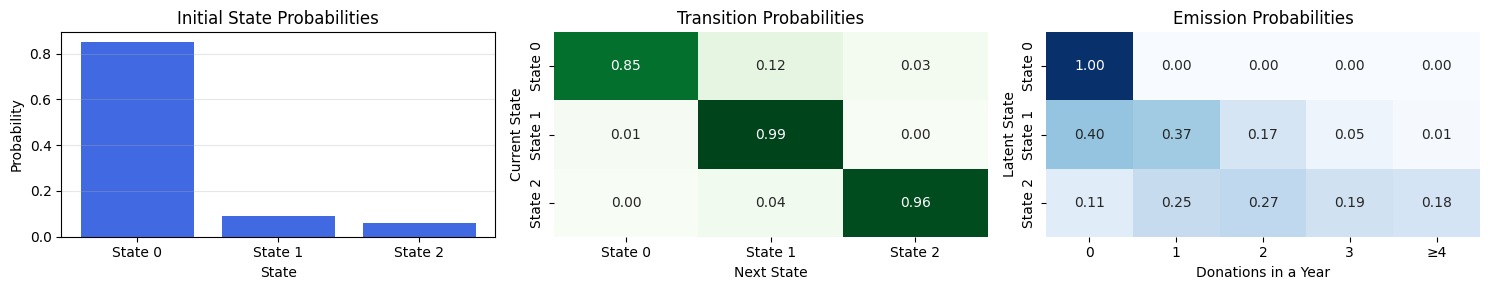

In [7]:
# ======================================================================
#  Diagnostics for the Poisson-HMM with Dirichlet intercepts
#     • log π  = log π_base  +  xπ · W_pi         (no explicit bias term)
#     • log A  = log A_base +  xA · W_A
# ======================================================================
import numpy as np
from  scipy.stats import poisson

K = 3                                                # latent-state count

# ── 1.  Extract learned parameters ───────────────────────────────────
lam        = pyro.param("rates").detach().cpu().numpy()            # (K,)

π_base     = pyro.param("pi_base_map").detach().cpu().numpy()      # (K,)   simplex
W_pi       = pyro.param("W_pi").detach().cpu().numpy()             # (K,2)

A_base     = pyro.param("A_base_map").detach().cpu().numpy()       # (K,K) each row simplex
W_A        = pyro.param("W_A").detach().cpu().numpy()              # (K,K,2)

# ── 2.  Reference covariate means  (population averages) ────────────
x_mean_pi  = cov_init_torch.mean(0).cpu().numpy()                  # (2,)   for π
x_mean_A   = cov_tran_torch.mean((0,1)).cpu().numpy()              # (2,)   for A

# ── 3.  π̄  and  Â   (mean initial probs & mean transition matrix) ──
def softmax_row(v):
    e = np.exp(v - v.max(-1, keepdims=True))
    return e / e.sum(-1, keepdims=True)

# initial probabilities
logits_pi = np.log(π_base) + W_pi @ x_mean_pi                      # (K,)
pi_mean   = softmax_row(logits_pi)                                 # (K,)

# transition matrix
A_mean = np.zeros((K, K))
for k in range(K):
    logits = np.log(A_base[k]) + W_A[k] @ x_mean_A                 # (K,)
    A_mean[k] = softmax_row(logits)

# ── 4.  Truncated-Poisson emission matrix (bins 0-4, bucket ≥4) ────
def build_emission_matrix_trunc_poisson(rates, max_k=4):
    S, G = len(rates), max_k + 1
    M = np.zeros((S, G))
    for s in range(S):
        for k in range(max_k):
            M[s, k] = poisson.pmf(k, rates[s])
        M[s, max_k] = 1 - poisson.cdf(max_k - 1, rates[s])
    return M

emissions_matrix = build_emission_matrix_trunc_poisson(lam, 4)

# ── 5.  Visual summary ──────────────────────────────────────────────
plot_hmm_params(
    transitions    = A_mean,
    initial_probs  = pi_mean,
    emissions      = emissions_matrix,
    emission_names = [str(i) for i in range(4)] + ["≥4"]
)

# Diagnostics

## Viterbi Algorithm

Viterbi decoder\
Goal : for each donor find the MAP latent path $z_{0:T}^\ast$.

Plug-in parameters (posterior means)\
$$\hat\pi_k = \frac{\alpha_{\pi,k}}{\sum_{j}\alpha_{\pi,j}},\qquad
  \hat A_{kj} = \frac{\alpha_{A_{k j}}}{\sum_{j'}\alpha_{A_{k j'}}},\qquad
  \hat\lambda_k = \frac{\alpha_k}{\beta_k}.$$

Dynamic programming\
Initial step\
$$\delta_0(k)=\log\hat\pi_k+\log\text{Poisson}(y_0\mid\hat\lambda_k).$$

Recursion for $t=1,\dots,T$\
$$\delta_t(j)=\max_k\bigl[\delta_{t-1}(k)+\log\hat A_{k j}\bigr]
               +\log\text{Poisson}(y_t\mid\hat\lambda_j),$$\
$$\psi_t(j)=\arg\max_k\bigl[\delta_{t-1}(k)+\log\hat A_{k j}\bigr].$$

Back-tracking\
Start with $z_T^\ast=\arg\max_k\delta_T(k)$, then\
$z_{t-1}^\ast=\psi_t(z_t^\ast)$ for $t=T,\dots,1$.

Cost $O(NTK^2)$ but vectorised in PyTorch, so only a loop on $t$.\
Output tensor paths\[N,T\] of integers 0…K-1, used for diagnostics and plots.


In [8]:
import torch, pyro, torch.nn.functional as F
import pyro.distributions as dist


def log_softmax_logits(logits, dim=-1):
    """log-softmax che restituisce direttamente i log-prob."""
    return logits - logits.logsumexp(dim, keepdim=True)


# ------------------------------------------------------------------
#  Viterbi per il modello con Dirichlet-intercept
#     x_pi : (N,2)   birth_year_norm , gender_code
#     x_A  : (N,T,2) ages_norm       , covid_years
# ------------------------------------------------------------------
def viterbi_paths_cov(obs, x_pi, x_A, K=3):
    with torch.no_grad():
        N, T = obs.shape

        # ── parametri appresi ───────────────────────────────────────
        lam      = pyro.param("rates")               # (K,)
        W_pi     = pyro.param("W_pi")                # (K,2)
        W_A      = pyro.param("W_A")                 # (K,K,2)

        pi_base  = pyro.param("pi_base_map")         # (K,)   simplex
        A_base   = pyro.param("A_base_map")          # (K,K)  righe simplex

        log_pi_base = pi_base.log()                  # (K,)
        log_A_base  = A_base.log()                   # (K,K)

        # ── emission log-prob P(y_t | z_t=k) ───────────────────────
        emis_log = torch.stack(
            [dist.Poisson(l).log_prob(obs) for l in lam]    # (K,N,T)
        ).permute(1, 2, 0)                                  # (N,T,K)

        # ── inizializzazione delta (t=0) ───────────────────────────
        logits0 = log_pi_base + x_pi @ W_pi.T               # (N,K)
        log_pi  = log_softmax_logits(logits0)               # normalizza
        delta   = log_pi + emis_log[:, 0]                   # (N,K)
        psi     = torch.zeros(N, T, K, dtype=torch.long)

        # ── forward pass t = 1 … T-1 ───────────────────────────────
        for t in range(1, T):
            x_t = x_A[:, t, :]                              # (N,2)

            # logits[n, k_prev, k_next] = log A_base[k_prev,k_next] +
            #                              W_A[k_prev,k_next] · x_t
            base   = log_A_base.unsqueeze(0)                # (1,K,K)
            slope  = (W_A.unsqueeze(0) * x_t[:, None, None, :]).sum(-1)
            logits = base + slope                           # (N,K,K)
            log_A  = log_softmax_logits(logits, dim=2)

            score, idx = (delta.unsqueeze(2) + log_A).max(1)  # max prev
            psi[:, t] = idx
            delta     = score + emis_log[:, t]

        # ── back-tracking ──────────────────────────────────────────
        paths        = torch.empty(N, T, dtype=torch.long)
        last_state   = delta.argmax(1)
        paths[:, -1] = last_state
        for t in range(T - 1, 0, -1):
            last_state    = psi[torch.arange(N), t, last_state]
            paths[:, t-1] = last_state

        return paths


# ------------------------------------------------------------------
#  Uso
# ------------------------------------------------------------------
paths = viterbi_paths_cov(obs_torch,
                          cov_init_torch,   # (N,2)
                          cov_tran_torch,   # (N,T,2)
                          K=3)

switch_rate = (paths[:, 1:] != paths[:, :-1]).any(1).float().mean()
print(f"switch rate = {switch_rate:.2%}")

switch rate = 78.58%


## State occupancy over time (population view)

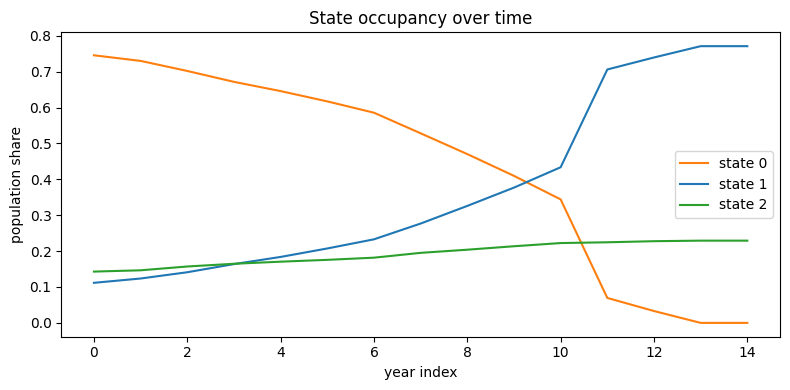

In [9]:
counts = np.apply_along_axis(lambda col: np.bincount(col, minlength=3),
                             0, paths)          # (K,T)
props  = counts / counts.sum(0, keepdims=True)

plt.figure(figsize=(8,4))
for k,c in enumerate(['tab:orange','tab:blue','tab:green']):
    plt.plot(props[k], label=f'state {k}', color=c)
plt.xlabel('year index'); plt.ylabel('population share')
plt.title('State occupancy over time'); plt.legend(); plt.tight_layout()

## Individual trajectories

Pick a few donors and overlay observations + decoded state for an easy interpretation of the model.

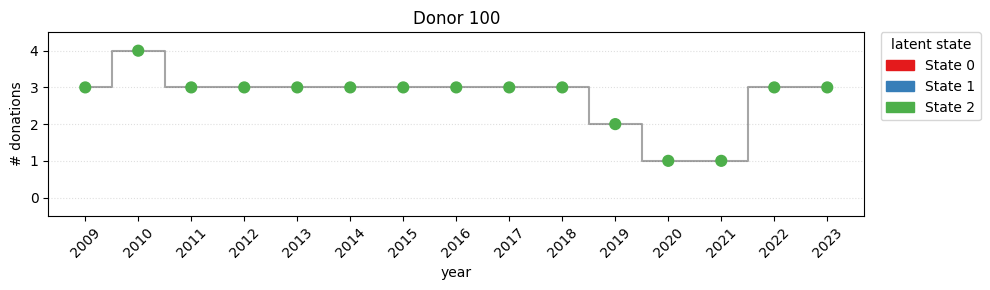

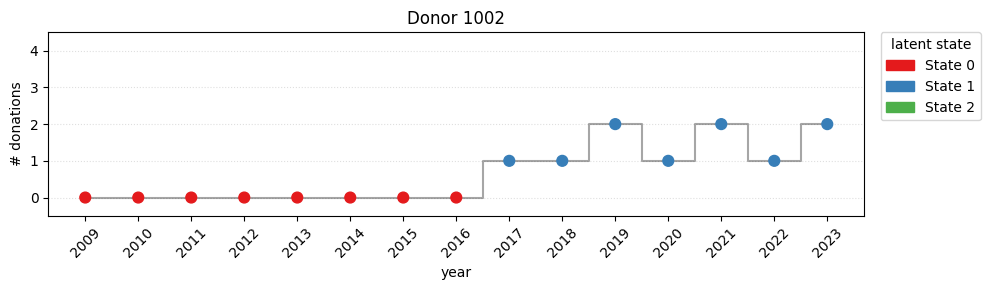

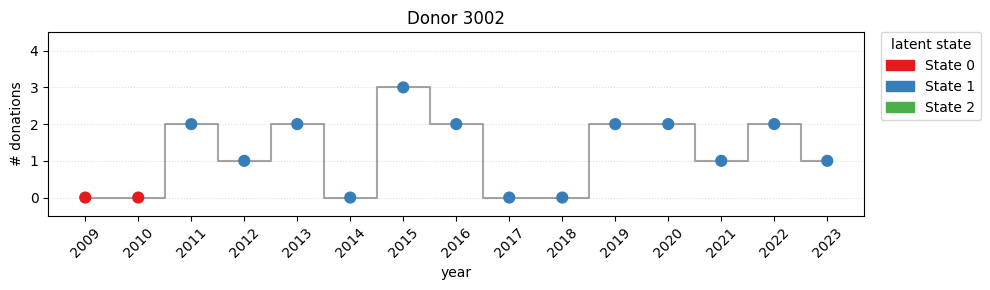

In [10]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
import numpy as np

# ------------------------------------------------------------
# globals
# ------------------------------------------------------------
K           = 3
state_cols  = ['#e41a1c', '#377eb8', '#4daf4a']          # 3 colori Set1
cmap        = ListedColormap(state_cols)
norm        = BoundaryNorm(np.arange(-0.5, K+0.5, 1), cmap.N)
years_axis  = np.arange(2009, 2024)                      # 2009 .. 2024
yticks_vals = np.arange(0, 5)                            # 0 .. 4

# ------------------------------------------------------------
def plot_one(idx):
    x = obs_torch[idx].cpu().numpy()       # osservazioni (T,)
    z = paths[idx]                         # stati latenti (T,)
    T = len(x)
    assert T == len(years_axis), "years_axis length must match T"

    plt.figure(figsize=(10, 3))
    plt.scatter(range(T), x, c=z, cmap=cmap, norm=norm, s=60, zorder=3)
    plt.step(range(T), x, where='mid', color='k', alpha=.35, zorder=2)

    # ---------- axis formatting ----------------------------------------
    plt.xticks(ticks=range(T), labels=years_axis, rotation=45)
    plt.yticks(ticks=yticks_vals)
    plt.ylim(-0.5, 4.5)                     # blocca a 0–4
    plt.grid(axis='y', linestyle=':', alpha=.4, zorder=1)

    # ---------- legenda discreta ---------------------------------------
    handles = [Patch(color=state_cols[k], label=f'State {k}') for k in range(K)]
    plt.legend(handles=handles, title='latent state',
               bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)

    plt.title(f'Donor {idx}')
    plt.xlabel('year')
    plt.ylabel('# donations')
    plt.tight_layout()
    plt.show()


for i in [100, 1002, 3002]:
    plot_one(i)

## Covariates

In [11]:
import torch, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from matplotlib.colors import Normalize

# ───────── 1. parametri appresi ────────────────────────────
rates   = pyro.param("rates").detach().cpu().numpy()          # (K,)

pi_base = pyro.param("pi_base_map").detach().cpu().numpy()    # (K,)
W_pi    = pyro.param("W_pi").detach().cpu().numpy()           # (K,2)

A_base  = pyro.param("A_base_map").detach().cpu().numpy()     # (K,K)
W_A     = pyro.param("W_A").detach().cpu().numpy()            # (K,K,2)

K, C_pi = W_pi.shape            # K stati, 2 covariate per π
_, _, C_A = W_A.shape           # 2 covariate per A

# ───────── 2. nomi covariate (adatta se necessario) ─────────
cov_names_pi = ["birth_year_norm", "gender_code"]             # C_pi = 2
cov_names_A  = ["ages_norm",       "covid_years"]             # C_A  = 2

state_cols = ['#e41a1c', '#377eb8', '#4daf4a']                # colori Set1

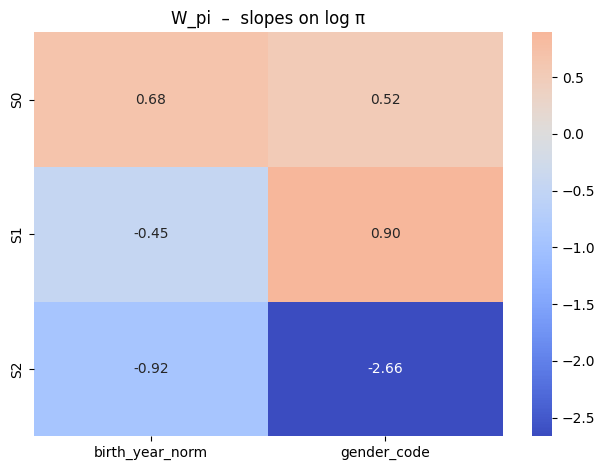

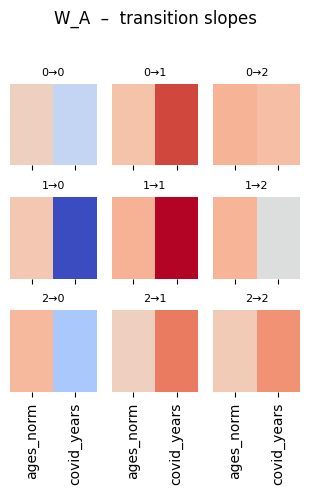

In [12]:
import matplotlib.pyplot as plt, seaborn as sns
import numpy as np

# ---------- nomi covariate -------------------------------------------------
cov_names_pi = ["birth_year_norm", "gender_code"]     # C_pi = 2
cov_names_A  = ["ages_norm",       "covid_years"]     # C_A  = 2

# ---------- slope su π  ----------------------------------------------------
def plot_W_pi_heat(W_pi):
    """
    Heat-map K × C_pi degli slope che modulano la distribuzione iniziale π.
    """
    sns.heatmap(W_pi,
                annot=True, fmt=".2f",
                xticklabels=cov_names_pi,
                yticklabels=[f"S{k}" for k in range(W_pi.shape[0])],
                cmap="coolwarm", center=0)
    plt.title("W_pi  –  slopes on log π")
    plt.tight_layout(); plt.show()

# ---------- slope su A  ----------------------------------------------------
def plot_W_A_heat(W_A):
    """
    Griglia K×K di heat-map 1×C_A: slope per ogni transizione k_prev → k_next.
    """
    K, _, C_A = W_A.shape
    fig, axes = plt.subplots(K, K,
                             figsize=(C_A*1.6, K*1.6),
                             sharex=True, sharey=True)

    vmin, vmax = W_A.min(), W_A.max()

    for i in range(K):
        for j in range(K):
            ax   = axes[i, j]
            mat  = W_A[i, j].reshape(1, -1)        # (1, C_A)
            sns.heatmap(mat, ax=ax,
                        vmin=vmin, vmax=vmax,
                        cmap="coolwarm", cbar=False,
                        xticklabels=cov_names_A,
                        yticklabels=[])
            ax.set_title(f"{i}→{j}", fontsize=8)

    plt.suptitle("W_A  –  transition slopes", y=1.02)
    plt.tight_layout(); plt.show()

# ---------------------------------------------------------------------------
#  chiamata
# ---------------------------------------------------------------------------
W_pi = pyro.param("W_pi").detach().cpu().numpy()     # (K, C_pi)
W_A  = pyro.param("W_A").detach().cpu().numpy()      # (K, K, C_A)

plot_W_pi_heat(W_pi)
plot_W_A_heat(W_A)

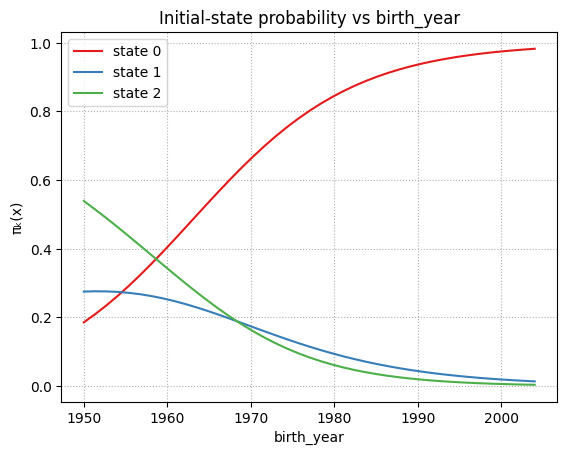

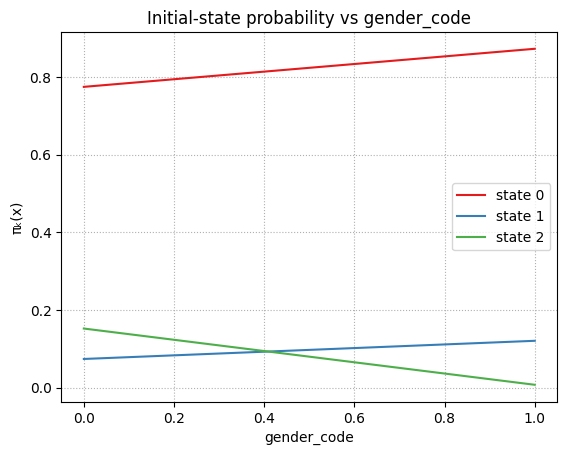

In [19]:
# ------------------------------------------------------------------
#  1.  Compute the (mean , std) that were used for z-scoring
# ------------------------------------------------------------------
# birth-year
birth_year_orig = df["birth_year"].to_numpy()
birth_year_mean = birth_year_orig.mean()
birth_year_std  = birth_year_orig.std()

# ages  (matrix N × T built from birth_year and calendar years)
years_num = np.array([int(c[2:]) for c in sorted([c for c in df.columns
                                                  if c.startswith("y_")])])
ages      = years_num[None, :] - df["birth_year"].to_numpy()[:, None]

ages_mean = ages.mean()
ages_std  = ages.std()

# ------------------------------------------------------------------
#  2.  Store them in the 'stats' dictionary
# ------------------------------------------------------------------
stats = {
    "birth_year_norm": (birth_year_mean, birth_year_std),
    "ages_norm":       (ages_mean,        ages_std)
}


# ==============================================================
#  Original (unnormalised) values and z-score utilities
# ==============================================================

def original_values(var_name: str) -> np.ndarray:
    """
    Return a 1-D NumPy array containing the covariate on
    its natural scale (no z-scoring).
    """
    if var_name == "birth_year_norm":
        return df["birth_year"].to_numpy()
    if var_name == "ages_norm":
        return ages.reshape(-1)
    if var_name == "gender_code":
        return np.array([0., 1.])          # binary
    if var_name == "covid_years":
        return np.array([0., 1.])          # binary
    raise ValueError(f"Unknown covariate {var_name}")


# mean / std used when the variable was z-scored ----------------
stats = {
    "birth_year_norm": (birth_year_mean, birth_year_std),
    "ages_norm":       (ages_mean,        ages_std)
}

def to_norm(var_name: str, x_orig: np.ndarray) -> np.ndarray:
    """
    Convert an array of ORIGINAL values to the z-scored scale
    expected by the model.
    """
    if var_name in stats:
        mu, sd = stats[var_name]
        return (x_orig - mu) / sd
    return x_orig          # binary variables stay unchanged
# ==============================================================
#  πₖ(x) versus a covariate (original scale on the x-axis)
# ==============================================================

def plot_pi_vs_cov_orig(var="birth_year_norm", grid_orig=None):
    if var not in cov_names_pi:
        raise ValueError(f"{var} is not a π covariate")

    idx      = cov_names_pi.index(var)
    col_orig = original_values(var)

    # grid of ORIGINAL values -----------------------------------
    if grid_orig is None:
        uniq = np.unique(col_orig)
        grid_orig = uniq if len(uniq) <= 3 else np.linspace(col_orig.min(),
                                                            col_orig.max(), 41)

    # reference vector (normalised scale) -----------------------
    x_ref_norm = x_pi_data.mean(0)                           # (2,)

    curves = []
    for v_orig in grid_orig:
        x_norm           = x_ref_norm.copy()
        x_norm[idx]      = to_norm(var, v_orig)
        logits           = log_pi0 + W_pi @ x_norm           # (K,)
        curves.append(softmax(logits))
    curves = np.vstack(curves)                               # (G, K)

    # plotting --------------------------------------------------
    for k, c in enumerate(state_cols):
        plt.plot(grid_orig, curves[:, k], color=c, label=f"state {k}")
    plt.xlabel(var.replace("_norm", ""));  plt.ylabel("πₖ(x)")
    plt.title(f"Initial-state probability vs {var.replace('_norm', '')}")
    plt.legend();  plt.grid(ls=":");  plt.show()


plot_pi_vs_cov_orig("birth_year_norm")
plot_pi_vs_cov_orig("gender_code")

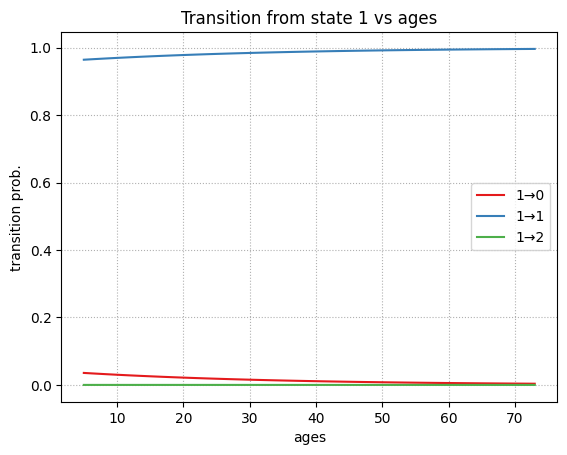

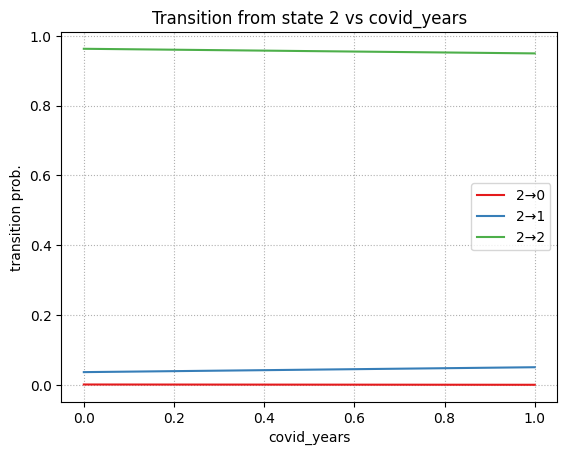

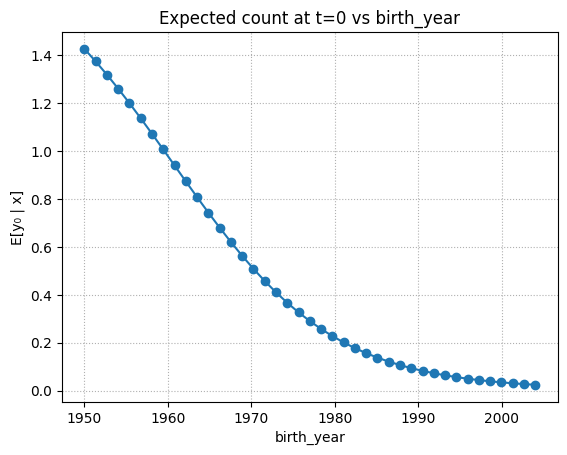

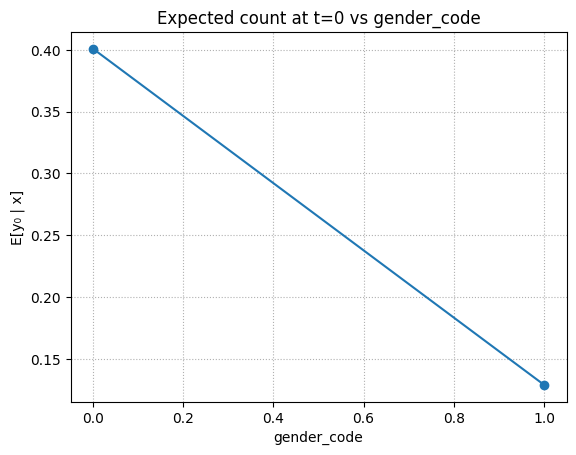

In [20]:
# ==============================================================
#  Transition probabilities versus a covariate (original scale)
# ==============================================================

def plot_trans_vs_cov_orig(var="ages_norm", prev_state=0, grid_orig=None):
    if var not in cov_names_A:
        raise ValueError(f"{var} is not an A covariate")
    if prev_state >= K:
        raise ValueError("prev_state out of range")

    idx      = cov_names_A.index(var)
    col_orig = original_values(var)

    if grid_orig is None:
        uniq = np.unique(col_orig)
        grid_orig = uniq if len(uniq) <= 3 else np.linspace(col_orig.min(),
                                                            col_orig.max(), 41)

    x_ref_norm = x_A_data.mean(axis=(0, 1))                  # (2,)
    mats       = np.zeros((len(grid_orig), K))

    for g, v_orig in enumerate(grid_orig):
        x_norm              = x_ref_norm.copy()
        x_norm[idx]         = to_norm(var, v_orig)
        logits              = log_A0[prev_state] + W_A[prev_state] @ x_norm
        mats[g]             = softmax(logits)

    for j, c in enumerate(state_cols):
        plt.plot(grid_orig, mats[:, j], color=c,
                 label=f"{prev_state}→{j}")
    plt.xlabel(var.replace("_norm", ""));  plt.ylabel("transition prob.")
    plt.title(f"Transition from state {prev_state} vs "
              f"{var.replace('_norm','')}")
    plt.legend();  plt.grid(ls=":");  plt.show()


plot_trans_vs_cov_orig("ages_norm",   prev_state=1)
plot_trans_vs_cov_orig("covid_years", prev_state=2)
# ==============================================================
#  Expected count E[y₀ | x] versus a π covariate (original scale)
# ==============================================================

def expected_y_orig(var="birth_year_norm", grid_orig=None):
    if var not in cov_names_pi:
        raise ValueError(f"{var} is not a π covariate")

    idx      = cov_names_pi.index(var)
    col_orig = original_values(var)

    if grid_orig is None:
        uniq = np.unique(col_orig)
        grid_orig = uniq if len(uniq) <= 3 else np.linspace(col_orig.min(),
                                                            col_orig.max(), 41)

    x_ref_norm = x_pi_data.mean(0)
    exp_vals   = []
    for v_orig in grid_orig:
        x_norm           = x_ref_norm.copy()
        x_norm[idx]      = to_norm(var, v_orig)
        pi_x             = softmax(log_pi0 + W_pi @ x_norm)     # (K,)
        exp_vals.append((pi_x * rates).sum())

    plt.plot(grid_orig, exp_vals, "-o")
    plt.xlabel(var.replace("_norm", ""));  plt.ylabel("E[y₀ | x]")
    plt.title(f"Expected count at t=0 vs {var.replace('_norm','')}")
    plt.grid(ls=":");  plt.show()


expected_y_orig("birth_year_norm")
expected_y_orig("gender_code")

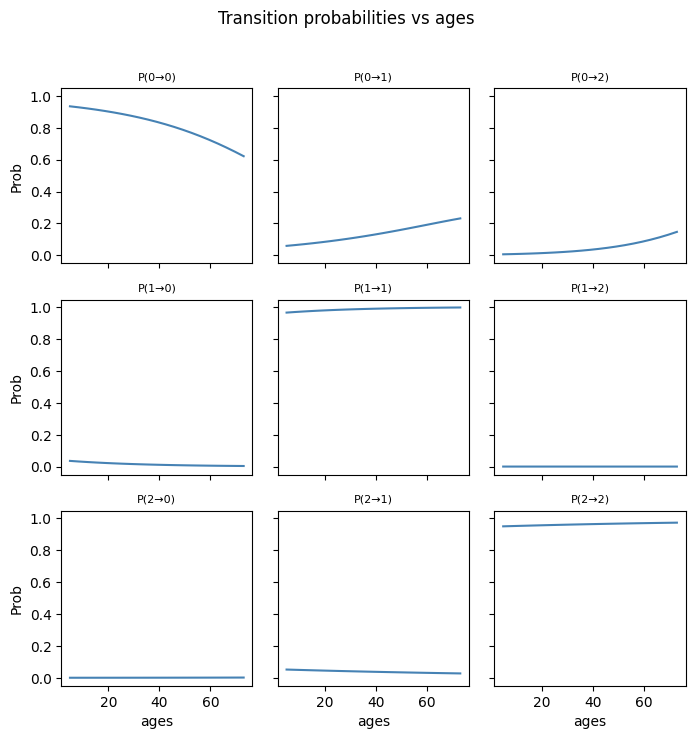

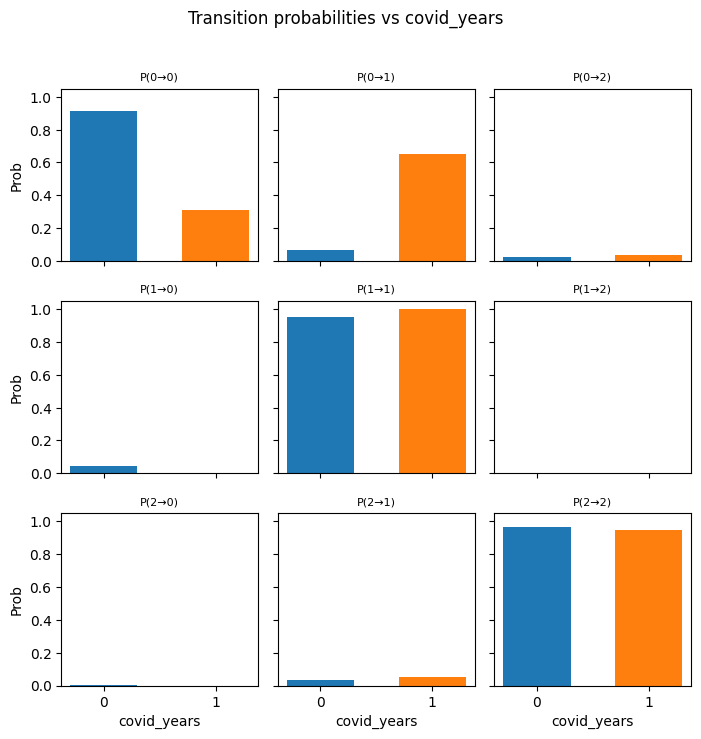

In [24]:
# ==============================================================
#  Heat-map helper: original-scale grids for the A–slopes model
# ==============================================================

import numpy as np, matplotlib.pyplot as plt, seaborn as sns

# ------------------------------------------------------------------
#  1.  ORIGINAL values of every covariate
# ------------------------------------------------------------------
def original_values(var: str) -> np.ndarray:
    """
    Return a 1-D NumPy array with the covariate on its
    natural (unnormalised) scale.
    """
    if var == "birth_year_norm":
        return df["birth_year"].to_numpy()
    if var == "ages_norm":
        return ages.reshape(-1)
    if var == "gender_code":
        return np.array([0., 1.])          # binary
    if var == "covid_years":
        return np.array([0., 1.])          # binary
    raise ValueError(f"Unknown covariate {var}")

# (mean , std) used during z-scoring
stats = {
    "birth_year_norm": (birth_year_mean, birth_year_std),
    "ages_norm":       (ages_mean,        ages_std)
}

def to_norm(var: str, x_orig: np.ndarray) -> np.ndarray:
    """Convert ORIGINAL values to the z-scored scale."""
    if var in stats:
        mu, sd = stats[var]
        return (x_orig - mu) / sd
    return x_orig                              # binary variables untouched
# ==============================================================
#  Transition grid  P(i→j | x)  versus ORIGINAL covariate value
# ==============================================================

def plot_transition_grid_orig(var_name: str,
                              cov_names:   list,
                              log_A0:      np.ndarray,   # (K , K )
                              W_A:         np.ndarray,   # (K , K , C)
                              full_cov:    np.ndarray,   # (N , T , C)  normalised
                              grid_vals_orig=None,
                              n_grid: int = 21):
    """
    Draw a K×K grid of curves/bars with the transition probability
    P(i→j | x) against one covariate on its ORIGINAL scale, while the
    model still receives z-scored inputs.
    """
    K, _, C = W_A.shape
    idx     = cov_names.index(var_name)

    # ---------- grid of ORIGINAL x values ------------------------------
    if grid_vals_orig is None:
        uniq = np.unique(original_values(var_name))
        if len(uniq) <= 2:                               # binary / categorical
            grid_vals_orig = uniq.astype(float)
            plot_mode      = "bar"
        else:                                            # continuous
            lo, hi = uniq.min(), uniq.max()
            grid_vals_orig = np.linspace(lo, hi, n_grid)
            plot_mode      = "line"
    else:
        plot_mode = "line"

    # ---------- convert ORIGINAL → NORMALISED --------------------------
    grid_vals_norm = to_norm(var_name, grid_vals_orig)

    # ---------- build transition matrices for every grid point ---------
    x_mean = full_cov.mean(axis=(0, 1))                  # (C,)
    mats   = np.empty((len(grid_vals_norm), K, K))       # (G , K , K)

    for g, v_norm in enumerate(grid_vals_norm):
        x_vec          = x_mean.copy()
        x_vec[idx]     = v_norm
        # logits[i , j] = log_A0[i , j] +  W_A[i , j] · x_vec
        logits         = log_A0 + np.tensordot(W_A, x_vec, axes=([2], [0]))
        probs          = np.exp(logits)
        probs         /= probs.sum(axis=1, keepdims=True)   # row soft-max
        mats[g]        = probs

    # ---------- plotting -----------------------------------------------
    fig, axes = plt.subplots(K, K,
                             figsize=(K * 2.4, K * 2.4),
                             sharex=True, sharey=True)

    for i in range(K):
        for j in range(K):
            ax = axes[i, j]
            if plot_mode == "line":
                ax.plot(grid_vals_orig, mats[:, i, j], color="steelblue")
            else:                                          # bar plot (binary)
                ax.bar(grid_vals_orig, mats[:, i, j],
                       width=0.6, color=['#1f77b4', '#ff7f0e'])
                ax.set_xticks(grid_vals_orig)

            ax.set_title(f"P({i}→{j})", fontsize=8)
            if i == K - 1:
                ax.set_xlabel(var_name.replace("_norm", ""))
            if j == 0:
                ax.set_ylabel("Prob")

    plt.suptitle(f"Transition probabilities vs "
                 f"{var_name.replace('_norm', '')}",
                 y=1.02)
    plt.tight_layout()
    plt.show()
# ==============================================================
#  Invoke the function for every A-covariate
# ==============================================================

cov_names_A = ["ages_norm", "covid_years"]     # order must match W_A's last dim
full_cov_A  = x_A_data                         # (N , T , 2) – already normalised

for var in cov_names_A:
    plot_transition_grid_orig(var,
                              cov_names_A,
                              log_A0,
                              W_A,
                              full_cov_A)